# Forecasting with Theta Model in Statsmodels


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fredapi import Fred


#fred = Fred(api_key='4c22e7f0cd5501e2a54e06a9baa2e929')

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=15)
plt.rc("lines", linewidth=3)
sns.set_style("darkgrid")


## HOUSTING DATA FROM FRED 



In [49]:
housing = pd.read_csv('HOUST.csv')
housing['DATE'] = pd.to_datetime(housing['DATE'])
housing.set_index('DATE', inplace=True)
housing.head()

,HOUST
DATE,
1959-01-01,1657.0
1959-02-01,1667.0
1959-03-01,1620.0
1959-04-01,1590.0
1959-05-01,1498.0


In [50]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 778 entries, 1959-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HOUST   778 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB


<AxesSubplot:xlabel='DATE'>

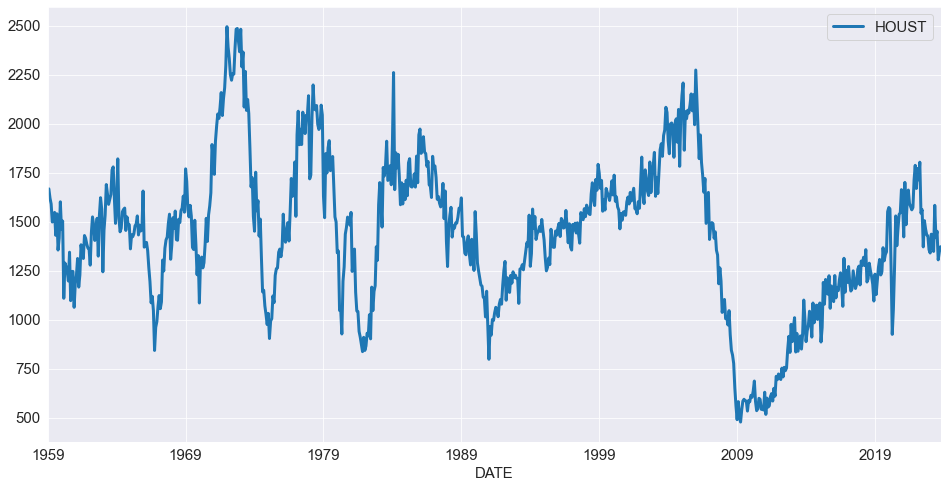

In [51]:
housing.plot()

<AxesSubplot:xlabel='DATE'>

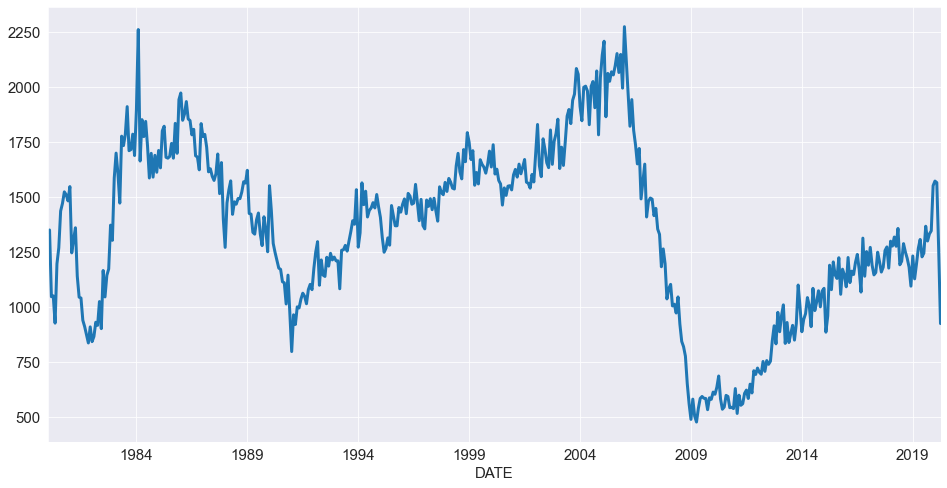

In [52]:
(housing
 .HOUST
 .loc["1980-01-01":"2020-04-01"]
 .plot()
)

In [53]:

housing.index.freq = housing.index.inferred_freq
housing_mod = housing.loc["1980-01-01":]
housing_mod

,HOUST
DATE,
1980-01-01,1341.0
1980-02-01,1350.0
1980-03-01,1047.0
1980-04-01,1051.0
1980-05-01,927.0
...,...
2023-06-01,1418.0
2023-07-01,1451.0
2023-08-01,1305.0


In [54]:

from statsmodels.tsa.forecasting.theta import ThetaModel

tm = ThetaModel(housing_mod)
res = tm.fit()
print(res.summary())



                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  526
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 21 Nov 2023   Deseas. Method:         Multiplicative
Time:                        21:24:18   Period:                             12
Sample:                    01-01-1980                                         
                         - 10-01-2023                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    -0.5844447487808743
alpha  0.6076011470120452
-------------------------


The model is first and foremost a forecasting method. Forecasts are produced using the forecast method from fitted model. Below we produce a hedgehog plot by forecasting 2-years ahead every 2 years.

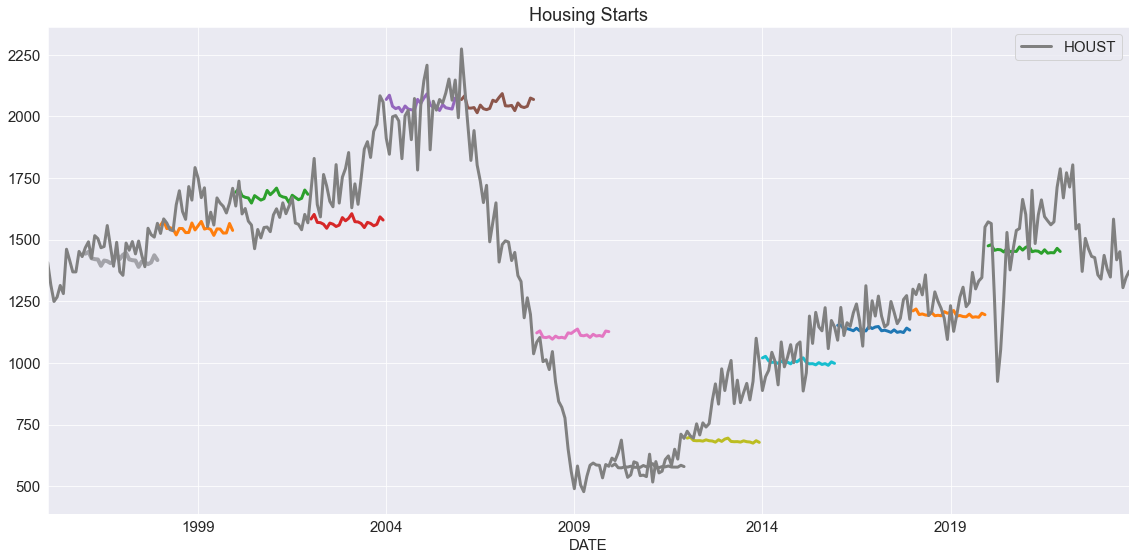

In [78]:
forecasts = {}
for year in range(1995, 2020, 2):
    sub = housing_mod[: str(year)]
    res = ThetaModel(sub).fit()
    fcast = res.forecast(24)
    forecasts[str(year)] = fcast
forecasts = pd.DataFrame(forecasts)
#Plot
ax = forecasts["1995":].plot(legend=False)
children = ax.get_children()
children[0].set_linewidth(4)
children[0].set_alpha(0.3)
children[0].set_color("#000000")
ax.set_title("Housing Starts")
housing_mod.loc["1995-01-01":].plot(ax =ax, c = 'grey')
plt.tight_layout(pad=1.0)

In [79]:

tm = ThetaModel(np.log(housing_mod), method="additive")
res = tm.fit(use_mle=True)
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  526
Method:                           MLE   Deseasonalized:                   True
Date:                Tue, 21 Nov 2023   Deseas. Method:               Additive
Time:                        21:36:11   Period:                             12
Sample:                    01-01-1980                                         
                         - 10-01-2023                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    0.00010134791844906886
alpha      0.660751655262943
----------------------------


In [80]:
res.forecast_components(12)

,trend,ses,seasonal
2023-11-01,0.000153,7.221664,0.009797
2023-12-01,0.000255,7.221664,0.005919
2024-01-01,0.000356,7.221664,0.008714
2024-02-01,0.000457,7.221664,0.013023
2024-03-01,0.000559,7.221664,-0.002608
2024-04-01,0.000660,7.221664,-0.010024
2024-05-01,0.000761,7.221664,-0.007634
2024-06-01,0.000863,7.221664,-0.007807
2024-07-01,0.000964,7.221664,0.002468
2024-08-01,0.001066,7.221664,-0.004387


## Personal Consumption Expenditure

https://fred.stlouisfed.org/series/NA000349Q



In [84]:
pce = pd.read_csv('NA000349Q.csv')
pce['DATE'] = pd.to_datetime(pce['DATE'])
pce = pce.rename(columns={'NA000349Q':'PCE'})
pce.set_index('DATE', inplace=True)
pce.head()

,PCE
DATE,
1947-01-01,36748.0
1947-04-01,39831.0
1947-07-01,39991.0
1947-10-01,45282.0
1948-01-01,40579.0


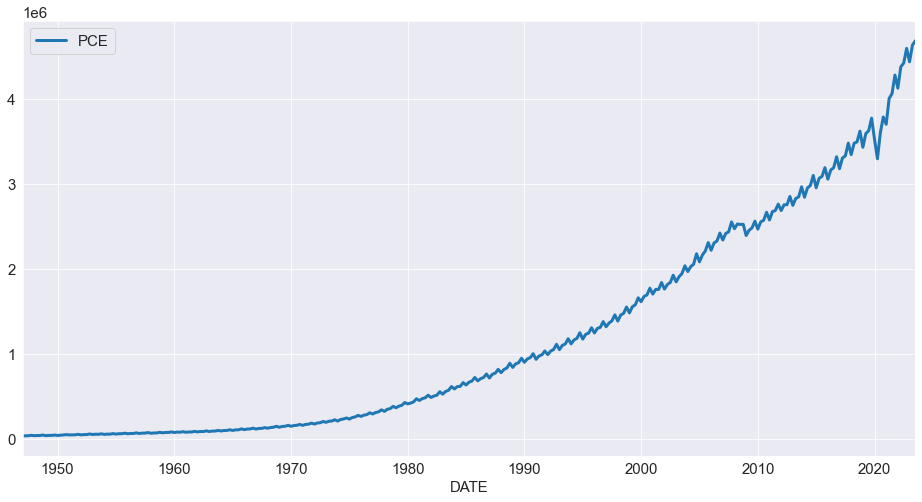

In [85]:
pce.index.freq = pce.index.inferred_freq
_ = pce.plot()

In [88]:
# Since this series is always positive, we model the Ln

mod = ThetaModel(np.log(pce))
res = mod.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                    PCE   No. Observations:                  307
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 21 Nov 2023   Deseas. Method:         Multiplicative
Time:                        21:45:26   Period:                              4
Sample:                    01-01-1947                                         
                         - 07-01-2023                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.016685560574476233
alpha   0.9436198747662246
--------------------------


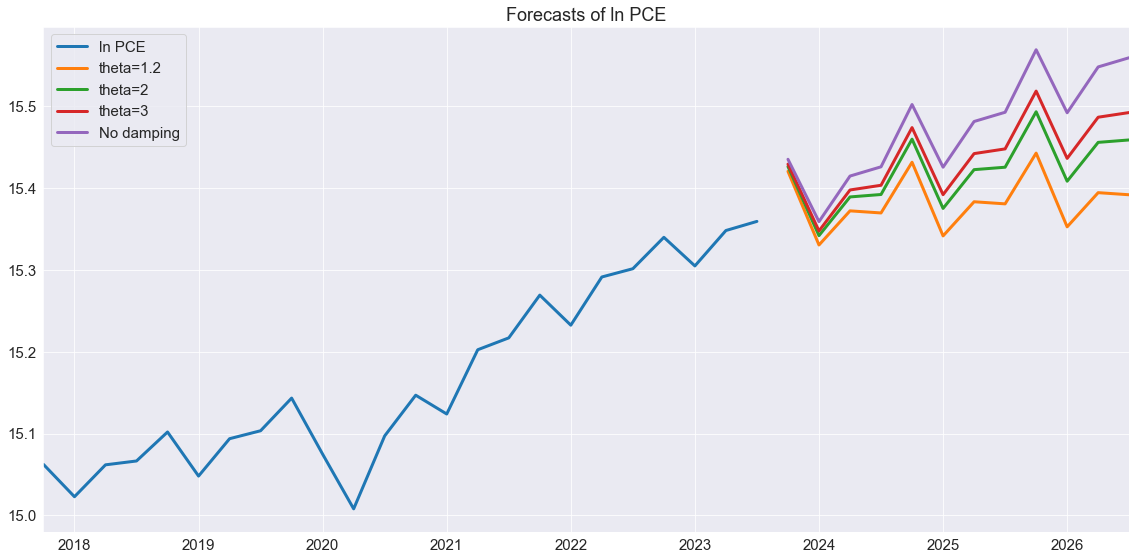

In [89]:
forecasts = pd.DataFrame(
    {
        "ln PCE": np.log(pce.PCE),
        "theta=1.2": res.forecast(12, theta=1.2),
        "theta=2": res.forecast(12),
        "theta=3": res.forecast(12, theta=3),
        "No damping": res.forecast(12, theta=np.inf),
    }
)
_ = forecasts.tail(36).plot()
plt.title("Forecasts of ln PCE")
plt.tight_layout(pad=1.0)

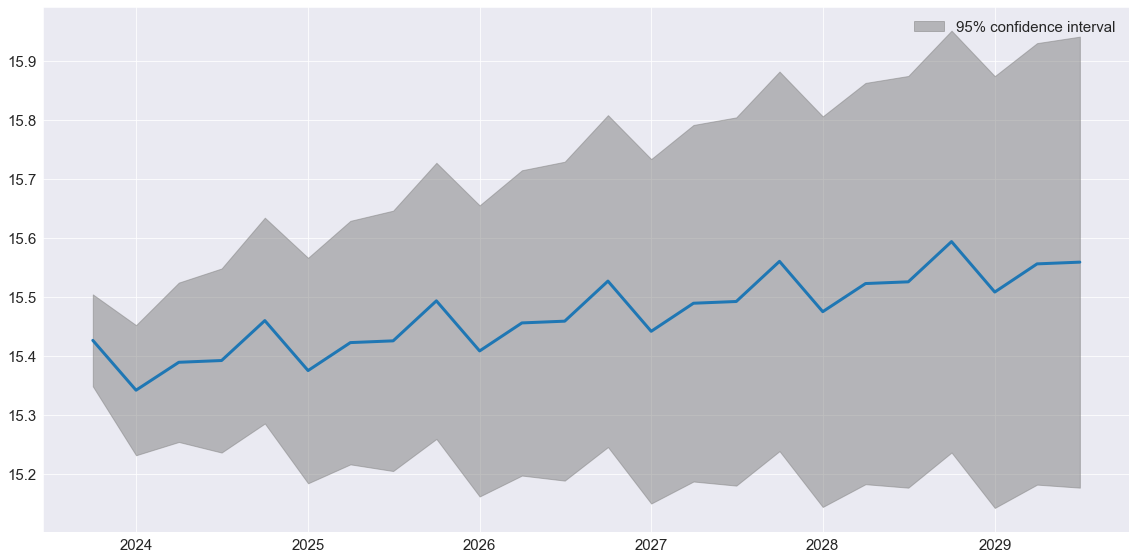

In [90]:

ax = res.plot_predict(24, theta=2)

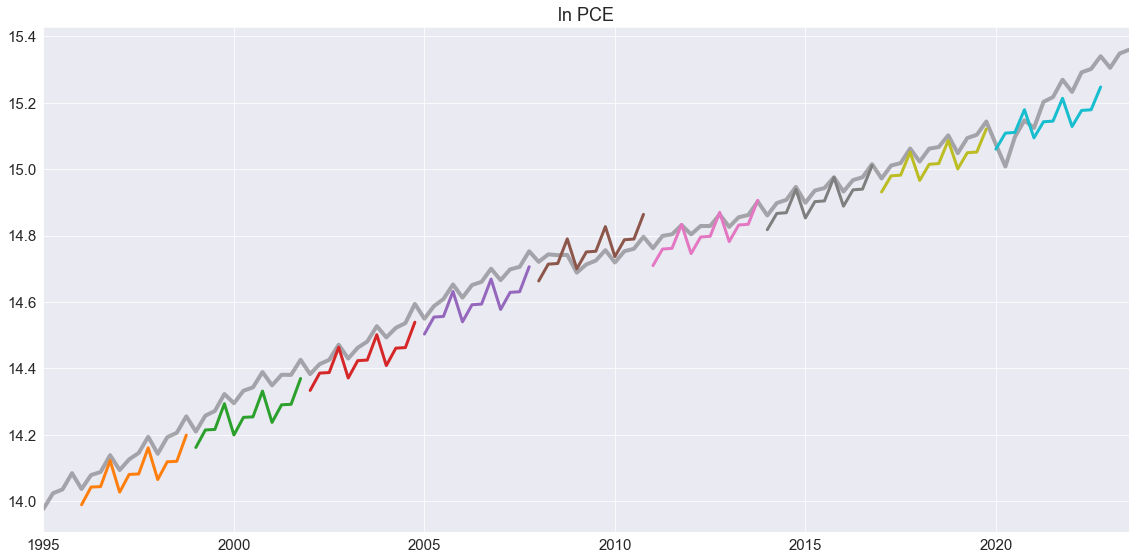

In [91]:
ln_pce = np.log(pce.PCE)
forecasts = {"ln PCE": ln_pce}
for year in range(1995, 2020, 3):
    sub = ln_pce[: str(year)]
    res = ThetaModel(sub).fit()
    fcast = res.forecast(12)
    forecasts[str(year)] = fcast
forecasts = pd.DataFrame(forecasts)
ax = forecasts["1995":].plot(legend=False)
children = ax.get_children()
children[0].set_linewidth(4)
children[0].set_alpha(0.3)
children[0].set_color("#000000")
ax.set_title("ln PCE")
plt.tight_layout(pad=1.0)